# Problem: 

**Şirketi terk edecek müşterileri tahmin edebilecek bir makine öğrenmesi modeli geliştirebilir misiniz?**

- Amaç bir bankanın müşterilerinin bankayı terk etme ya da terk etmeme durumunun tahmin edilmesidir.

- Müşteri terkini tanımlayan olay müşterinin banka hesabını kapatmasıdır.

**Veri Seti Hikayesi:**

- 10000 gözlemden ve 12 değişkenden oluşmaktadır. 
- Bağımsız değişkenler müşterilere ilişkin bilgiler barındırmaktadır.
- Bağımlı değişken müşteri terk durumunu ifade etmektedir.

**Değişkenler:**

- Surname : Soy isim
- CreditScore : Kredi skoru
- Geography : Ülke (Germany/France/Spain)
- Gender : Cinsiyet (Female/Male)
- Age : Yaş
- Tenure : Kaç yıllık müşteri
- Balance : Bakiye
- NumOfProducts : Kullanılan banka ürünü
- HasCrCard : Kredi kartı durumu (0=No,1=Yes)
- IsActiveMember : Aktif üyelik durumu (0=No,1=Yes)
- EstimatedSalary : Tahmini maaş
- Exited : Terk mi değil mi? (0=No,1=Yes)


# Data Understanding

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);


In [3]:
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [4]:
churn = pd.read_csv("churn.csv", index_col=0)

In [5]:
df=churn.copy()

In [6]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df.shape

(10000, 13)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [9]:
df.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
df.nunique()

CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [11]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True) 

By means of inplace=Truce customerId and Surname columns are droped permanently because of independicies with target value 'Exited'.

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


### Churn

In [14]:
# Churners vs Non-Churners 
df['Exited'].value_counts() 

0    7963
1    2037
Name: Exited, dtype: int64

In [15]:
exited = df.groupby('Exited')
exited.mean().T

Exited,0,1
CreditScore,651.853196,645.351497
Age,37.408389,44.837997
Tenure,5.033279,4.932744
Balance,72745.296779,91108.539337
NumOfProducts,1.544267,1.475209
HasCrCard,0.707146,0.699067
IsActiveMember,0.554565,0.360825
EstimatedSalary,99738.391772,101465.677531


In [16]:
df.groupby('Gender').Exited.mean()

Gender
Female    0.250715
Male      0.164559
Name: Exited, dtype: float64

In [17]:
df_plot = df.groupby('Gender').Exited.mean().reset_index()
plot_data = [
    go.Bar(
        x=df_plot['Gender'],
        y=df_plot['Exited'],
        width = [0.5, 0.5],
        marker=dict(
        color=['green', 'blue'])
    )
]
plot_layout = go.Layout(
        xaxis={"type": "category"},
        yaxis={"title": "Churn Rate"},
        title='Gender',
        plot_bgcolor  = 'rgb(243,243,243)',
        paper_bgcolor  = 'rgb(243,243,243)',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

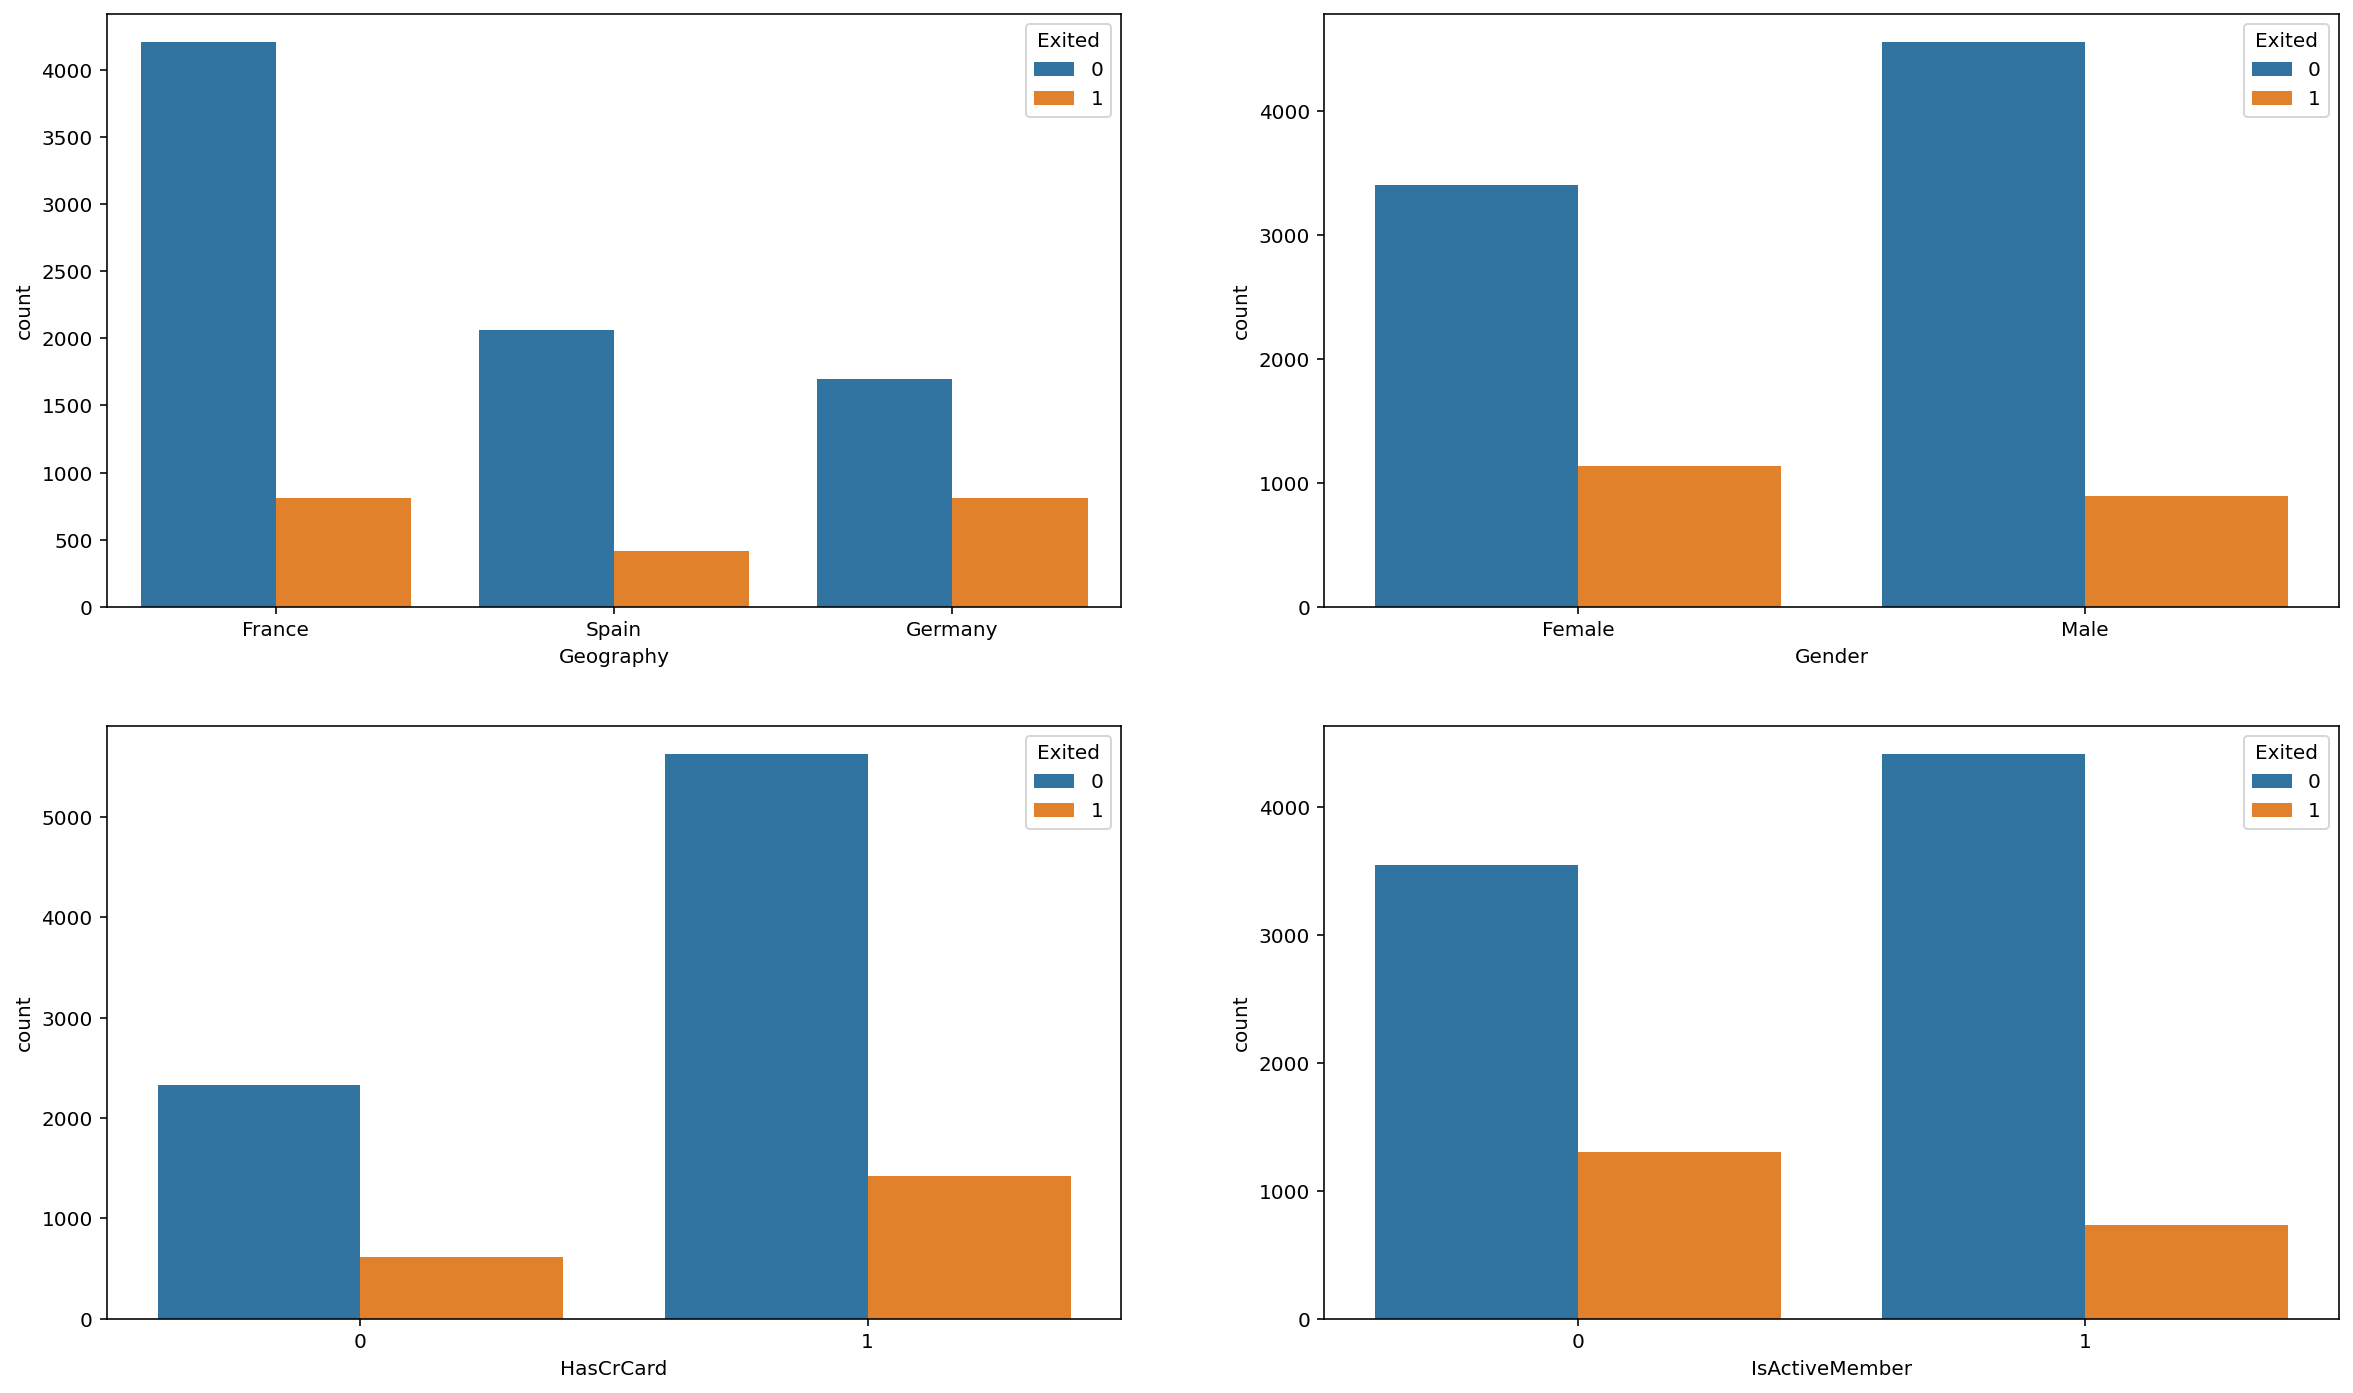

In [18]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

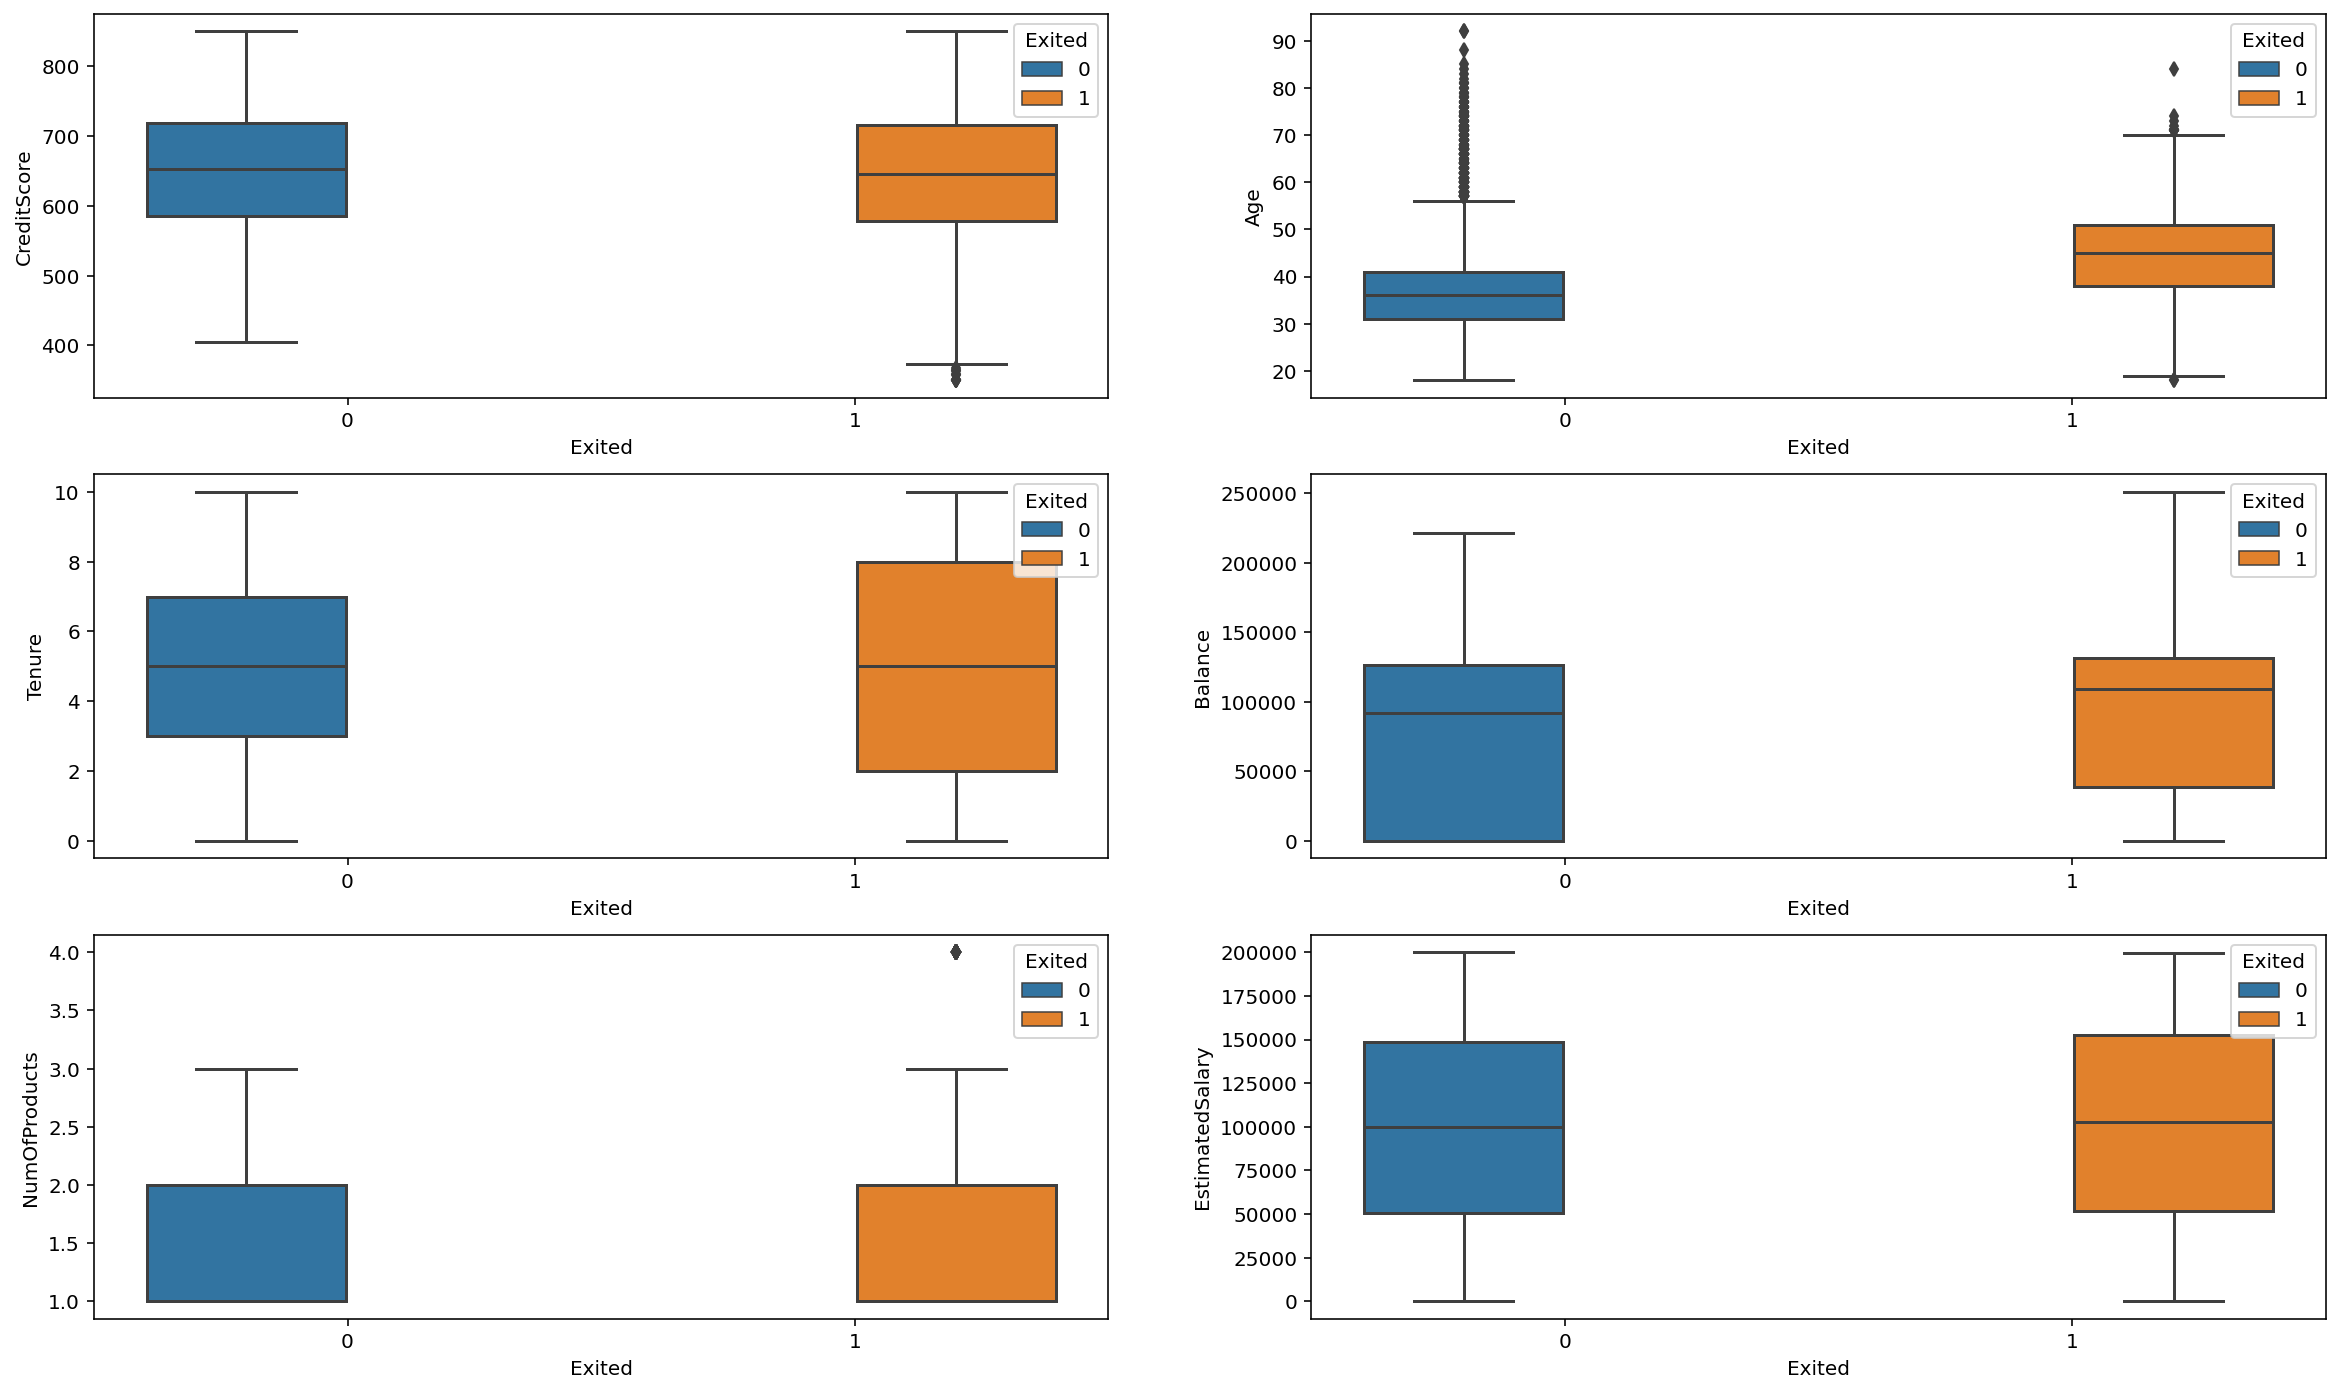

In [19]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

In [20]:
ggtable= df.pivot_table("Exited", index="Gender", columns="Geography")
ggtable

Geography,France,Germany,Spain
Gender,,,
Female,0.203450,0.375524,0.212121
Male,0.127134,0.278116,0.131124


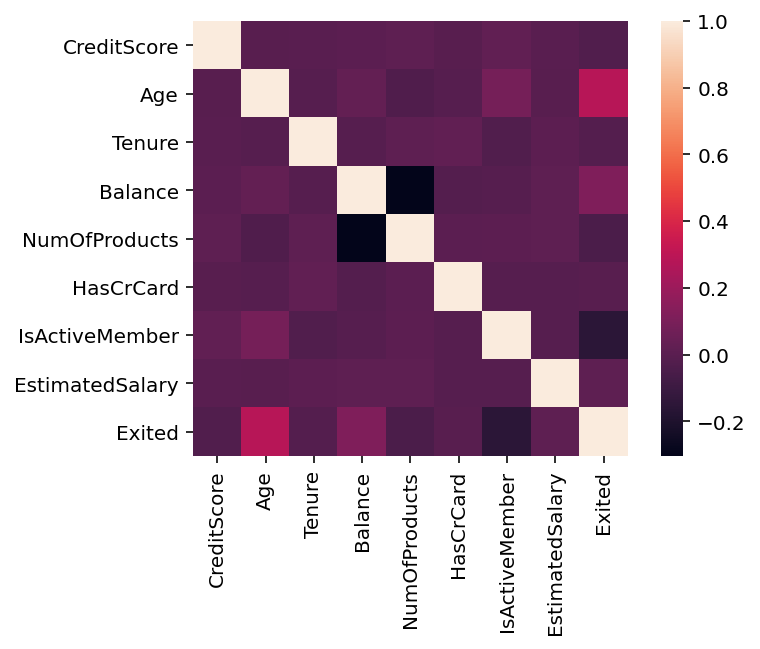

In [21]:
correlation = df.corr()
sns.heatmap(correlation.T, square=True, annot=False, fmt="d", cbar=True)

# Shuffling the dataset
churn_dataset = churn_dataset.reindex(np.random.permutation(churn_dataset.index))

# Data Preprocessing

In [22]:
# Features and Labels 
X = df.drop("Exited",axis=1)
y = df["Exited"]

In [23]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
RowNumber,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
3,502,France,Female,42,8,159660.80,3,1,0,113931.57
4,699,France,Female,39,1,0.00,2,0,0,93826.63
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [24]:
y.head()

RowNumber
1    1
2    0
3    1
4    0
5    0
Name: Exited, dtype: int64

In [25]:
labels=list(X.columns.values)
labels

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

## Feature Engineering

- Handling Outliers
- Binning
- One Hot Encoding
- Scaling

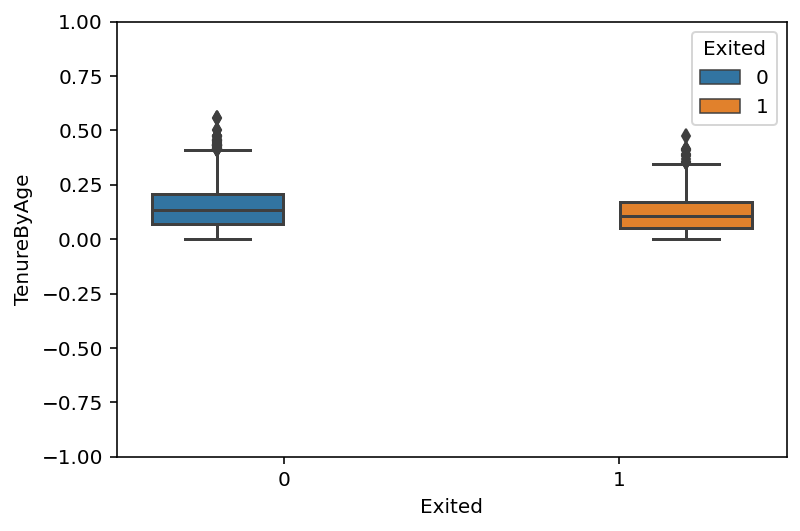

In [73]:
# Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age:
df['TenureByAge'] = df.Tenure/(df.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 1)
plt.show()

In [74]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,TenureByAge
RowNumber,,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,0,0.047619
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,0.024390
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0.190476
4,699,39,1,0.00,2,0,0,93826.63,0,0,0,0,0.025641
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,0.046512


In [77]:
#Lastly we introduce a variable to capture credit score given age to take into account credit behaviour visavis adult life
df['CreditScoreGivenAge'] = df.CreditScore/(df.Age)

In [78]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,TenureByAge,CreditScoreGivenAge
RowNumber,,,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0,0,0,0.047619,14.738095
2,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,0.024390,14.829268
3,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0.190476,11.952381
4,699,39,1,0.00,2,0,0,93826.63,0,0,0,0,0.025641,17.923077
5,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,0.046512,19.767442


### Hanldling Outliers

In [79]:
#Dropping the outlier rows with standard deviation
def outlier_detection(data, column):
  factor = 3
  upper_lim = data[column].mean () + data[column].std () * factor
  lower_lim = data[column].mean () - data[column].std () * factor

  data = data[(data[column] < upper_lim) & (data[column] > lower_lim)]
  return data

In [81]:
df.shape

(10000, 14)

In [82]:
outlier= ['Balance', 'EstimatedSalary', 'CreditScore', 'Age']
for i in outlier:
  df_clean= outlier_detection(df, column=i)
  print('Processed on '+ i+', Shape: '+ str(df_clean.shape))

Processed on Balance, Shape: (10000, 14)
Processed on EstimatedSalary, Shape: (10000, 14)
Processed on CreditScore, Shape: (9992, 14)
Processed on Age, Shape: (9867, 14)


### Binning

In [90]:
df_clean.shape

(9867, 14)

In [89]:
df_clean.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,TenureByAge,CreditScoreGivenAge
count,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.00000,9867.00000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000,9867.000000
mean,650.363028,38.437924,5.012466,76597.617276,1.530455,0.70528,0.50978,100097.250720,0.205331,0.250937,0.247998,0.546265,0.138888,17.995567
std,96.701488,9.677250,2.891887,62393.121800,0.582326,0.45594,0.49993,57492.107833,0.403964,0.433575,0.431873,0.497880,0.089615,5.307280
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.00000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,5.833333
25%,583.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.00000,51057.790000,0.000000,0.000000,0.000000,0.000000,0.065217,14.222222
50%,652.000000,37.000000,5.000000,97325.150000,1.000000,1.00000,1.00000,100200.400000,0.000000,0.000000,0.000000,1.000000,0.131579,17.361111
75%,717.500000,43.000000,7.000000,127677.095000,2.000000,1.00000,1.00000,149376.125000,0.000000,1.000000,0.000000,1.000000,0.200000,21.031250
max,850.000000,70.000000,10.000000,250898.090000,4.000000,1.00000,1.00000,199992.480000,1.000000,1.000000,1.000000,1.000000,0.555556,46.888889


In [97]:
df_clean['CreditSegment'] = pd.cut(df_clean['CreditScore'], bins=[350,450,550,650,750,850], labels=[1,2,3,4,5])
df_clean.drop(columns='CreditScore', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
df_clean.head()

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,TenureByAge,CreditScoreGivenAge,CreditSegment
RowNumber,,,,,,,,,,,,,,
1,42,2,0.00,1,1,1,101348.88,1,0,0,0,0.047619,14.738095,3
2,41,1,83807.86,1,0,1,112542.58,0,0,1,0,0.024390,14.829268,3
3,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0.190476,11.952381,2
4,39,1,0.00,2,0,0,93826.63,0,0,0,0,0.025641,17.923077,4
5,43,2,125510.82,1,1,1,79084.10,0,0,1,0,0.046512,19.767442,5


### One-Hot Encoding 

One-Hot Encoding is the process of creating dummy variables. It simply creates additional features based on the number of unique values in the categorical feature. Every unique value in the category will be added as a feature.

In [101]:
df_clean = pd.get_dummies(df_clean,drop_first=True)
df_clean.head()

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,TenureByAge,CreditScoreGivenAge,CreditSegment_2,CreditSegment_3,CreditSegment_4,CreditSegment_5
RowNumber,,,,,,,,,,,,,,,,,
1,42,2,0.00,1,1,1,101348.88,1,0,0,0,0.047619,14.738095,0,1,0,0
2,41,1,83807.86,1,0,1,112542.58,0,0,1,0,0.024390,14.829268,0,1,0,0
3,42,8,159660.80,3,1,0,113931.57,1,0,0,0,0.190476,11.952381,1,0,0,0
4,39,1,0.00,2,0,0,93826.63,0,0,0,0,0.025641,17.923077,0,0,1,0
5,43,2,125510.82,1,1,1,79084.10,0,0,1,0,0.046512,19.767442,0,0,0,1


### Splitting the dataset into the Training and Test sets 

In [107]:
X = df_clean.drop("Exited",axis=1)
y = df_clean["Exited"]
X.head()

,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,TenureByAge,CreditScoreGivenAge,CreditSegment_2,CreditSegment_3,CreditSegment_4,CreditSegment_5
RowNumber,,,,,,,,,,,,,,,,
1,42,2,0.00,1,1,1,101348.88,0,0,0,0.047619,14.738095,0,1,0,0
2,41,1,83807.86,1,0,1,112542.58,0,1,0,0.024390,14.829268,0,1,0,0
3,42,8,159660.80,3,1,0,113931.57,0,0,0,0.190476,11.952381,1,0,0,0
4,39,1,0.00,2,0,0,93826.63,0,0,0,0.025641,17.923077,0,0,1,0
5,43,2,125510.82,1,1,1,79084.10,0,1,0,0.046512,19.767442,0,0,0,1


In [108]:
y.head()

RowNumber
1    1
2    0
3    1
4    0
5    0
Name: Exited, dtype: int64

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  
                                                    test_size = 0.2,  
                                                    random_state = 12345) 


In [111]:
print(len(X_train))
print(len(X_test))

7893
1974


### Feature Scaling 

In [112]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test) 

# Model Building

## Choosing the best classification model to use

In [117]:
#Creating a python list of models will be applied
models = []
models.append(('LR', LogisticRegression()))
models.append(("Gaussian Naive Bayes",GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', SVC(gamma='auto')))
models.append(('GradientBoosting', GradientBoostingClassifier()))
models.append(("LightGBM", LGBMClassifier()))
models.append(("XGBoost", XGBClassifier()))


In [118]:
for name, model in models:
        y_pred = model.fit(X_train,y_train).predict(X_test)
        res = accuracy_score(y_test,y_pred)*100
        print(name+": "+str(res)+"%")

LR: 81.71225937183384%
Gaussian Naive Bayes: 80.69908814589665%
KNN: 82.92806484295846%
CART: 77.55825734549138%
RF: 85.76494427558258%
SVC: 85.86626139817629%
GradientBoosting: 86.01823708206688%
LightGBM: 85.56231003039514%
XGBoost: 85.81560283687944%


In [125]:
model = RandomForestClassifier(n_estimators = 100, random_state = 0)
y_pred = model.fit(X_train, y_train).predict(X_test)
print("Our accuracy is:", accuracy_score(y_pred, y_test)*100, "%")

Our accuracy is: 86.17021276595744 %


### Feature importance plot for XGBoost Model

from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10,8))

plot_importance(xgb_model, ax=ax)

## Confusion Matrix

In [127]:
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_test, y_pred)) 

[[1514   56]
 [ 217  187]]


From the confusion matrix, we can compute the following metrics:

- True Positives(TP) = 1514
- True Negatives(TN) = 187
- False Positives(FP) = 217
- False Negatives(FN) = 56
- Precision = TP/(TP+FP) = 
- Recall = TP/(TP+FN) = 
- Accuracy = (TP+TN)/(TP+TN+FP+FN) = 

![alternatif metin](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

# Conclusion

## We can improve our model’s overall performance by:

- Adding more data (we have around 2k rows for this example)
- Adding more features
- More feature engineering
- Trying other models
- Hyper-parameter tuning

# Referances

- https://www.geeksforgeeks.org/python-customer-churn-analysis-prediction/
- https://towardsdatascience.com/churn-prediction-3a4a36c2129a
- https://towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266
- https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114